# Exercise: Cauchy Location Posterior

This notebook contains the codes from exercise developed in the [pdf](https://www.github.com/phd-bayesian-statistics/tree/master/notes/). The exercise treats about the the location parameter of the [Cauchy Disitribution](https://en.wikipedia.org/wiki/Cauchy_distribution). Let $X \sim \mathcal{C}(\theta, 1)$. We want to make inferences about $\theta \in \mathbb{R}$. The ideia is to analyse the asymptotic behaviour and compare it to the Bernstein-Mises theorem. 

In [1]:
import numpy as np
from scipy.optimize import root_scalar
from scipy.stats import norm, cauchy

import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sns
import arviz as az
plt.style.use('ggplot')

from tabulate import tabulate
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# this ensures reproducibility
random_integer = 10000
ro = np.random.RandomState(random_integer)

## Maximum likelihood estimator

Here we calculate numerically the Maximum Likelihood Estimator and we especify the second derivative of the log-likelihood. We use the Brent's method in order to search for local minimums and maximums of the log likelihood function. 

In [2]:
# data
x = np.array([-5, -3, 0, 2, 4, 5, 7, 9, 11, 14])
# log-likelihood
l = lambda theta, x: -10*np.log(np.pi) - (np.log(1 + (x-theta)**2)).sum()
# derivative of log-likelihood
dl = lambda theta, x: ((x - theta)/(1 + (x - theta)**2)).sum()
# second derivative of log-likelihood
ddl = lambda theta, x: 2*(((x - theta)**2 - 1)/((x - theta)**2 + 1)**2).sum()

We search the solution in the interval $(\min(x_i), \max(x_i))$.

In [3]:
sol = root_scalar(f = dl, bracket = (min(x), max(x)), method = "brentq", args = (x,))
if sol.converged: 
    print("The solution is {}".format(sol.root))

The solution is 4.531359933259603


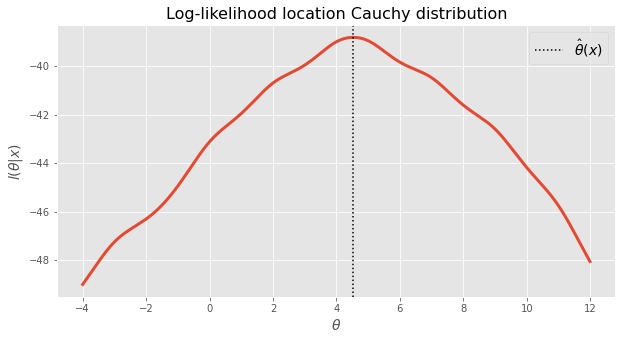

In [4]:
range_theta = np.arange(-4, 12, 0.01)
likelihood_func = np.array([l(t,x) for t in range_theta])

fig, ax = plt.subplots(figsize = (10,5))
ax.plot(range_theta, likelihood_func, linewidth = 3)
ax.axvline(sol.root, color = "black", linestyle = ":", label = r"$\hat{\theta}(x)$")
ax.set_title("Log-likelihood location Cauchy distribution", fontsize = 16)
ax.set_xlabel(r"$\theta$", fontsize = 14)
ax.set_ylabel(r"$l(\theta | x)$", fontsize = 14)
ax.legend(fontsize = 14)

plt.savefig("../images/log-likelihood.png", bbox_inches = "tight")
plt.show()

The second derivative of the log-likelihood  evaluates at the MLE is 

In [5]:
ddl(sol.root, x)

-1.2312071388339643

In [6]:
sigma_n = 1/abs(ddl(sol.root, x))

## Priors

Here we draw the suggested informative priors. 

In [7]:
mu = 0
fig, ax = plt.subplots(1, 3, figsize = (15,7))
fig.suptitle("Comparing the informative priors", fontsize = 15, y = 0.94)
for e, parameter in enumerate([1,10,100]): 
    rv_1 = norm(loc = mu, scale = parameter)
    rv_2 = cauchy(loc = mu, scale = parameter)
    t = np.arange(-4*parameter, 4*parameter, 0.1)
    ax[e].plot(t, rv_1.pdf(t), 'b-', lw=2,label=r'$N({}, {})$'.format(mu,parameter**2))
    ax[e].plot(t, rv_2.pdf(t), 'r-', lw=2,label=r'$C({}, {})$'.format(mu,parameter))
    ax[e].legend()
plt.savefig("../images/priors-comparison.png", bbox_inches = "tight")

## Evaluating posterior distribution and asymptotic behaviour

We use the Monte Carlo Markov Chain procedure to sample from $p(\theta|x)$ and we compare it to the Normal distribution deduced by the [Bernstein–von Mises theorem](https://en.wikipedia.org/wiki/Bernstein%E2%80%93von_Mises_theorem). 

In [8]:
def mcmc_routine(prior, obs, scale=1, n_samples = 5000, tune = 2000): 
    
    cauchy_model = pm.Model()
    with cauchy_model: 
        # Priors for unknown model parameters
        if prior == 'flat':
            theta = pm.Flat("theta") 
        elif prior == 'normal': 
            theta = pm.Normal("theta", mu = 0, sigma = scale)
        elif prior == 'cauchy': 
            theta = pm.Cauchy("theta", alpha = 0, beta = scale)
        # Likelihood (sampling distribution) of the observations 
        x_obs = pm.Cauchy("x_obs", alpha = theta, beta = 1, observed=obs)
        
    with cauchy_model: 
        # Draw posterior samples 
        sampling = pm.sample(n_samples, return_inferencedata=False, random_seed = random_integer, tune = tune) 
        
    return sampling

In [9]:
sample1 = mcmc_routine(prior = 'flat', obs = x)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 2_000 tune and 5_000 draw iterations (4_000 + 10_000 draws total) took 6 seconds.


In [10]:
sample2 = mcmc_routine(prior = 'normal', obs = x, scale = 1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 2_000 tune and 5_000 draw iterations (4_000 + 10_000 draws total) took 5 seconds.


In [11]:
sample3 = mcmc_routine(prior = 'normal', obs = x, scale = 10)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 2_000 tune and 5_000 draw iterations (4_000 + 10_000 draws total) took 6 seconds.


In [12]:
sample4 = mcmc_routine(prior = 'normal', obs = x, scale = 100)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 2_000 tune and 5_000 draw iterations (4_000 + 10_000 draws total) took 5 seconds.


In [13]:
sample5 = mcmc_routine(prior = 'cauchy', obs = x, scale = 1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 2_000 tune and 5_000 draw iterations (4_000 + 10_000 draws total) took 5 seconds.


In [14]:
sample6 = mcmc_routine(prior = 'cauchy', obs = x, scale = 10)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 2_000 tune and 5_000 draw iterations (4_000 + 10_000 draws total) took 6 seconds.


In [15]:
sample7 = mcmc_routine(prior = 'cauchy', obs = x, scale = 100)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 2_000 tune and 5_000 draw iterations (4_000 + 10_000 draws total) took 5 seconds.


The posterior oobtained by Schervish has $P(\theta \ge 5 | X = x) = 0.3560$. Let's compare with out sample and take the nearest. 

In [16]:
text = "Using the prior {}, we obtained the probability of being greater than 5 equal to {}"
print(text.format("Flat", np.mean(sample1.theta>=5)))
print(text.format("N(0,1)", np.mean(sample2.theta>=5)))
print(text.format("N(0,100)", np.mean(sample3.theta>=5)))
print(text.format("N(0,10000)", np.mean(sample4.theta>=5)))
print(text.format("C(0,1)", np.mean(sample5.theta>=5)))
print(text.format("C(0,10)", np.mean(sample6.theta>=5)))
print(text.format("C(0,100)", np.mean(sample7.theta>=5)))

Using the prior Flat, we obtained the probability of being greater than 5 equal to 0.3569
Using the prior N(0,1), we obtained the probability of being greater than 5 equal to 0.0
Using the prior N(0,100), we obtained the probability of being greater than 5 equal to 0.3251
Using the prior N(0,10000), we obtained the probability of being greater than 5 equal to 0.3493
Using the prior C(0,1), we obtained the probability of being greater than 5 equal to 0.1437
Using the prior C(0,10), we obtained the probability of being greater than 5 equal to 0.3022
Using the prior C(0,100), we obtained the probability of being greater than 5 equal to 0.3485


In [17]:
t = np.arange(-1,11,0.01)
X = norm(loc = sol.root, scale =  np.sqrt(sigma_n))
sample_normal = X.pdf(t)

In [18]:
fig, ax = plt.subplots(figsize = (6,6))

sns.distplot(sample1.theta, kde = True, hist = False, 
             kde_kws = {"bw": 0.15, "linestyle": "-"}, color = 'darkblue', 
             ax = ax, label = "Numerical integration")
sns.lineplot(t, sample_normal, linestyle = ':', color = 'black', 
             ax = ax, label = 'Normal approximation.')

ax.set_xlim(0,10)
ax.set_ylabel("Density")
ax.set_title('Comparison between normal approximation and posteriori')
plt.savefig('../images/comparison-simple-case.png', bbox_inches = "tight")
plt.show()

In [19]:
az.summary(sample1)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
theta  4.583  1.498   1.608    7.508      0.024    0.017    3831.0  3728.0   

       ess_bulk  ess_tail  r_hat  
theta    3926.0    4447.0    1.0

Comparing some characteristics of Normal distribution and Numerical approximation of the posteriori.  

In [20]:
norm_charac = {"median": X.median(), 
               "2.5th per": X.ppf(0.025), 
               "25th per": X.ppf(0.25), 
               "75th per": X.ppf(0.75),
               "0.975th per": X.ppf(0.975), 
               "P(X>=mean(x))": X.sf(x.mean())}
posterior_charac = {"median": np.quantile(sample1.theta, q = 0.5), 
                    "2.5th per": np.quantile(sample1.theta, q = 0.025), 
                    "25th per": np.quantile(sample1.theta, q = 0.25), 
                    "75th per": np.quantile(sample1.theta, q = 0.75),
                    "0.975th per": np.quantile(sample1.theta, q = 0.975), 
                    "P(X>=mean(x))": (sample1.theta >= x.mean()).mean()}

table = [[key, norm_charac[key], posterior_charac[key]] for key in norm_charac.keys()]

print(tabulate(table, headers=[' ', 'Normal approx', 'Posterior (MCMC)']))

                 Normal approx    Posterior (MCMC)
-------------  ---------------  ------------------
median                4.53136              4.57545
2.5th per             2.76499              1.55876
25th per              3.92349              3.75738
75th per              5.13923              5.38569
0.975th per           6.29773              7.79505
P(X>=mean(x))         0.557943             0.5598


Plot with other prioris.

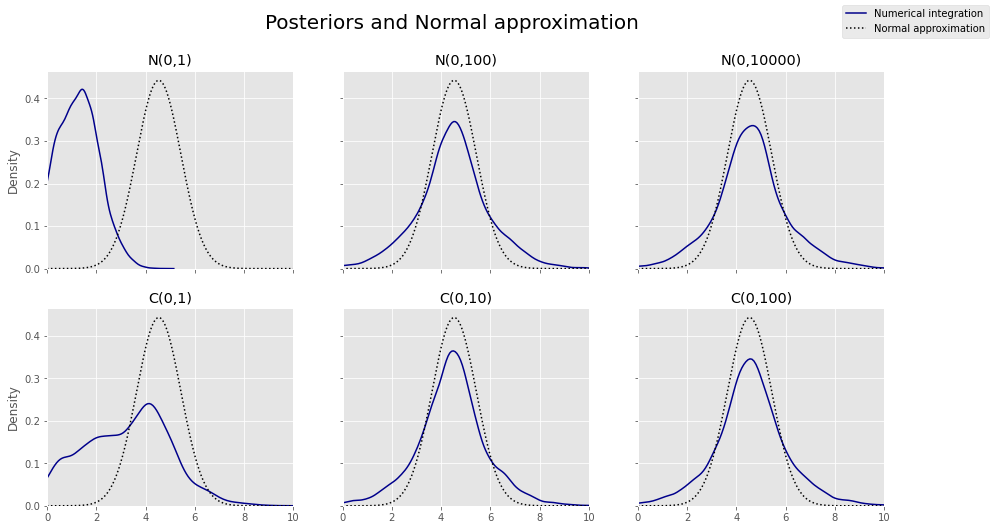

In [21]:
fig, ax = plt.subplots(2,3,figsize = (15,8), sharey = True, sharex = True)

samples = [[sample2.theta, sample3.theta, sample4.theta], [sample5.theta, sample6.theta, sample7.theta]]
priors = [['N(0,1)','N(0,100)','N(0,10000)'], ['C(0,1)','C(0,10)','C(0,100)']]

for i in range(2):
    for j in range(3): 
        sns.distplot(samples[i][j], kde = True, hist = False, 
                     kde_kws = {"bw": 0.15, "linestyle": "-"}, color = 'darkblue', 
                     ax = ax[i][j], label = " ")
        sns.lineplot(t, sample_normal, linestyle = ':', color = 'black', 
                     ax = ax[i][j], label = ' ')

        ax[i][j].set_xlim(0,10)
        ax[i][j].set_ylabel("Density")
        ax[i][j].legend([],[], frameon=False)
        ax[i][j].set_title(priors[i][j])
        
handles, _ = ax[0][0].get_legend_handles_labels()
labels = ['Numerical integration', 'Normal approximation']
fig.legend(handles, labels)
fig.suptitle("Posteriors and Normal approximation", fontsize = 20)

plt.savefig('../images/comparison-other-cases.png', bbox_inches = "tight")
plt.show()

## Simulations with larger samples

In [22]:
theta0 = 5
n_values = [20, 50, 100, 500, 1000, 10000]
simulations = {n:ro.standard_cauchy(n) + theta0 for n in n_values}

First we need to obtain the parameters of the normal distribution. 

In [23]:
def norm_parameters_calc(sample): 
    # Finds the solution. 
    sol = root_scalar(f = dl, bracket = (min(sample), max(sample)), method = "brentq", args = (sample,))
    # The mean will be the MLE
    mean = sol.root
    # The variance is the inverse of the second derivative of log-likelihood. 
    sigma_n = 1/abs(ddl(sol.root, sample))
    sigma = np.sqrt(sigma_n)
    
    assert sol.converged == True
    assert ddl(sol.root, x) < 0
    
    return mean, sigma

In [24]:
normal_approx_param = {n: norm_parameters_calc(simulations[n]) for n in n_values}
normal_approx_param

{20: (4.903949242266397, 0.34344507509538524),
 50: (4.702113932546705, 0.20307771962458235),
 100: (4.994277743793381, 0.14241864667515142),
 500: (5.032804428970018, 0.06337679039636655),
 1000: (4.99930033870421, 0.04480851348580602),
 10000: (4.998071621699272, 0.014354298528772952)}

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 2_000 tune and 5_000 draw iterations (4_000 + 10_000 draws total) took 5 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 2_000 tune and 10_000 draw iterations (4_000 + 20_000 draws total) took 8 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 2_000 tune and 10_000 draw iterations (4_000 + 20_000 draws total) took 11 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 2_000 tune and 10_000 draw iterations (4_000 + 20_000 draws total) took 11 seconds.
The acceptance probability does not match the target. It is 0.8937874140363885, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]


Sampling 2 chains for 2_000 tune and 10_000 draw iterations (4_000 + 20_000 draws total) took 21 seconds.


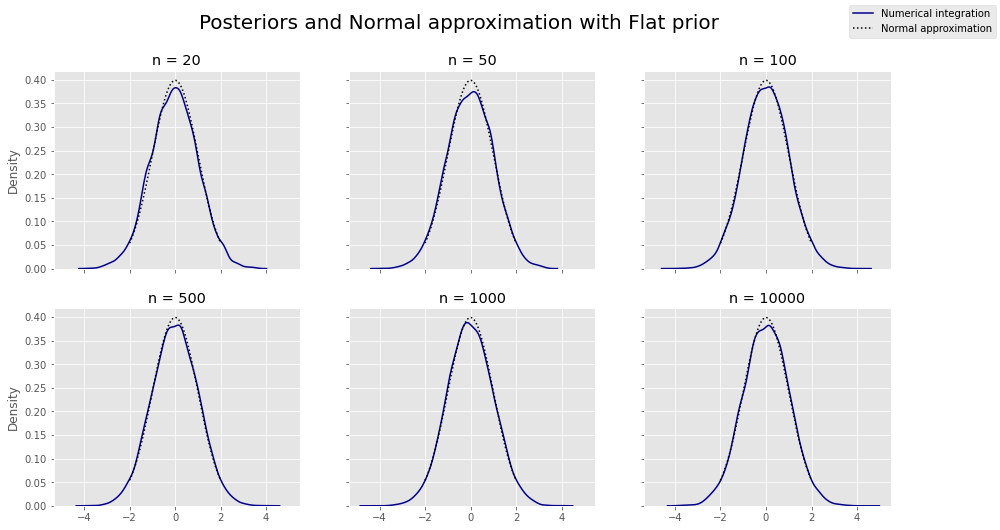

In [28]:
fig, ax = plt.subplots(2,3,figsize = (15,8), sharey = True, sharex = True)
t = np.arange(-2,2,0.01)

for k, n in enumerate(n_values):
    
    i = k//3
    j = k%3
    
    sample = mcmc_routine(prior = 'flat', obs = simulations[n], n_samples = min(10000,100*n), tune = 2000)
    scaled_sample = (sample.theta - normal_approx_param[n][0])/normal_approx_param[n][1]
    X = norm(loc = 0, scale = 1)
    sample_normal = X.pdf(t)
    
    sns.distplot(scaled_sample, kde = True, hist = False, 
                 kde_kws = {"bw": 0.15, "linestyle": "-"}, color = 'darkblue', 
                 ax = ax[i][j], label = " ")
    sns.lineplot(t, sample_normal, linestyle = ':', color = 'black', 
                 ax = ax[i][j], label = ' ')

    #ax[i][j].set_xlim(0,10)
    ax[i][j].set_ylabel("Density")
    ax[i][j].legend([],[], frameon=False)
    ax[i][j].set_title("n = {}".format(n))
    
handles, _ = ax[0][0].get_legend_handles_labels()
labels = ['Numerical integration', 'Normal approximation']
fig.legend(handles, labels)
fig.suptitle("Posteriors and Normal approximation with Flat prior", fontsize = 20)

plt.savefig('../images/normal-approximation-large-sample.png', bbox_inches = "tight")
plt.show()